Student Name:
- Afia Ibnath
- Daniel Yu

# Assignment 5

Welcome to the assignment for week 5.

## Task 5: Optical Flow

### Task 5.1: Block Matching

* Implement the block matching method as shown in the lecture
* Take two frames from the datasets "lane_detection" or "copter_flight" with variable distances in time (1, 2, x) and compute the vector flow field
* Display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

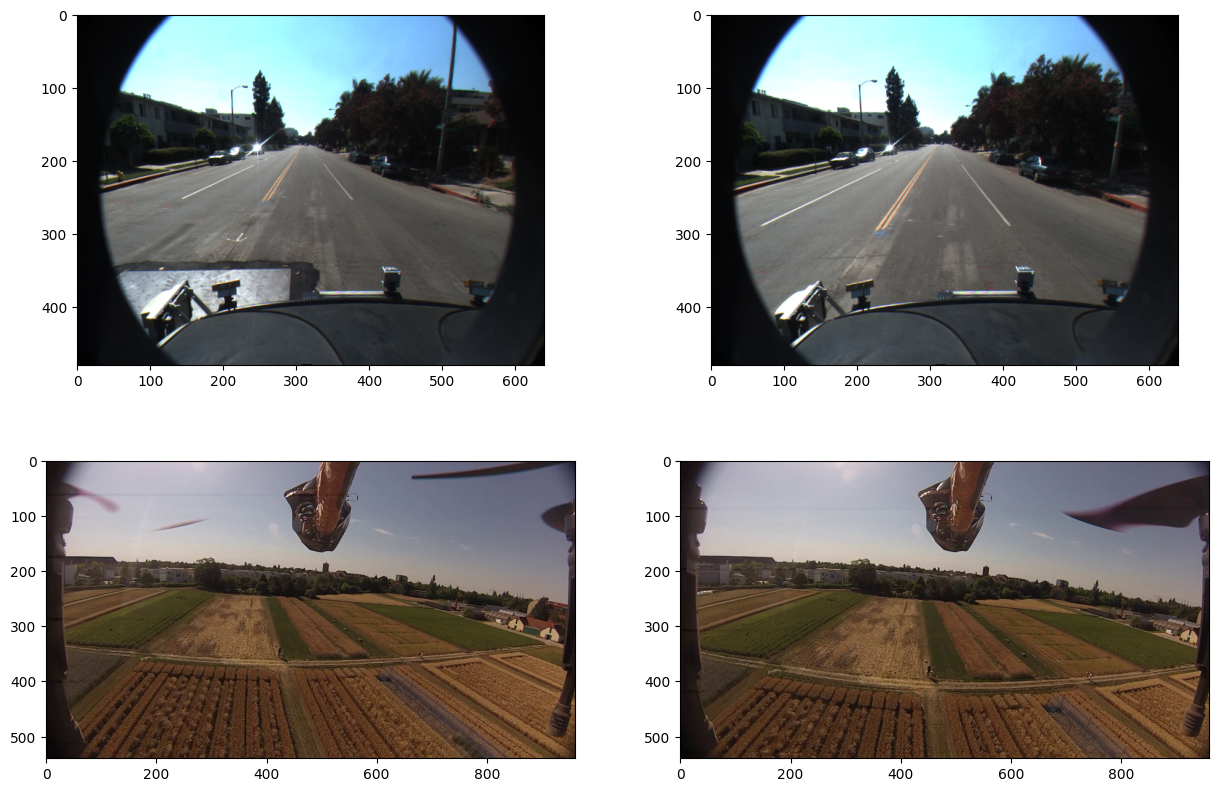

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, color, feature
import numpy as np
import matplotlib.patches as patches

# Chose other images if you like
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00001.png')

copter1 = io.imread('images/copter_flight/frame050.jpg')
copter2 = io.imread('images/copter_flight/frame052.jpg')


fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(lane1)
ax12.imshow(lane2)

ax21.imshow(copter1)
ax22.imshow(copter2)

In [1]:
# code here
def get_template_bounds(img,x,y,stride):
    H,W = img.shape
    y_min = max(0, y - stride)
    y_max = min(H, y + stride + 1)
    x_min = max(0, x - stride)
    x_max = min(W, x + stride + 1)
    return y_min, y_max, x_min ,x_max

In [2]:
def block_matching(img_t, img_t_1, W_search, W_match, step=1):
    height, width = img_t.shape
    flow_vectors = np.zeros((height, width,2), dtype=np.int32)

    search_patch= (W_search+1) // 2
    match_patch =  (W_match+1) // 2
    
    for y in range(0, height, step):
        for x in range(0, width, step):
            y_min, y_max, x_min ,x_max= get_template_bounds(img_t,x,y,match_patch)
            search_temp=img_t[y_min:y_max, x_min:x_max]
            min_ssd = np.inf
            min_dx, min_dy = 0, 0
            
            for dy in range(-search_patch, search_patch + 1):
                for dx in range(-search_patch, search_patch + 1):
                    y_min_m, y_max_m, x_min_m ,x_max_m = get_template_bounds(img_t_1,x+dx,y+dy,match_patch)
                    if (y_max_m - y_min_m == search_temp.shape[0] and
                            x_max_m - x_min_m == search_temp.shape[1]):
                        match_temp=img_t_1[y_min_m:y_max_m, x_min_m:x_max_m]
                        ssd = np.sum((search_temp - match_temp) ** 2)
                        if ssd < min_ssd:
                            min_ssd = ssd
                            min_dx, min_dy = dx, dy
            flow_vectors[y,x]=  [min_dx, min_dy]
    return flow_vectors

In [6]:
img_t, img_t_1 =color.rgb2gray(lane1), color.rgb2gray(lane2)

flow_v= block_matching(img_t, img_t_1,  W_search= 120 , W_match= 40, step=40)

In [36]:
flow_v.shape

(480, 640, 2)

In [7]:
def plot_flow_vectors(img_t, flow_vectors, step=10):
    height, width = img_t.shape
    y, x = np.mgrid[0:height:step, 0:width:step]
    u = flow_vectors[::step, ::step, 0]  
    v = flow_vectors[::step, ::step, 1]  
    plt.figure(figsize=(10, 10))
    plt.imshow(img_t, cmap='gray', origin='upper')
    plt.quiver(x, y, u, v, color='red', angles='xy', scale_units='xy', scale=1)
    plt.title("Optical Flow Vectors")
    plt.axis('off')
    plt.show()

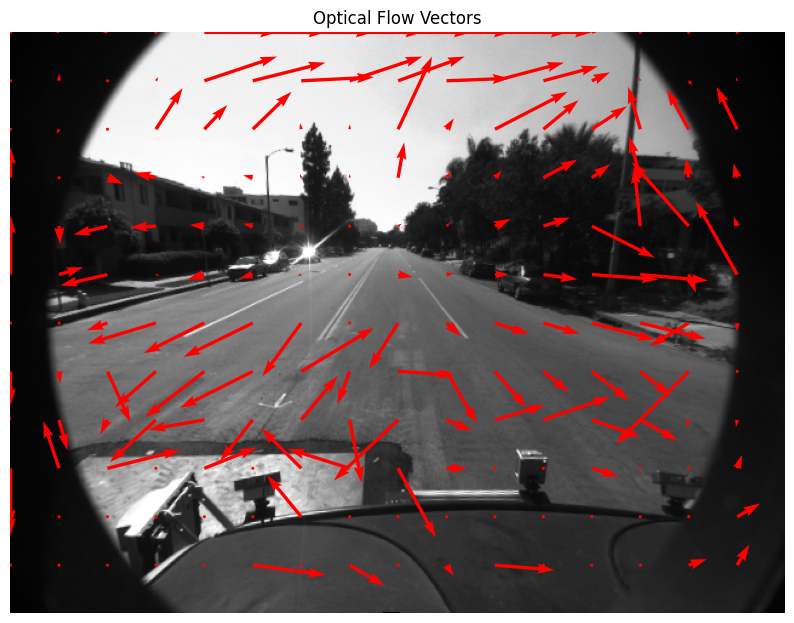

In [6]:
plot_flow_vectors(img_t, flow_v, step=40) 

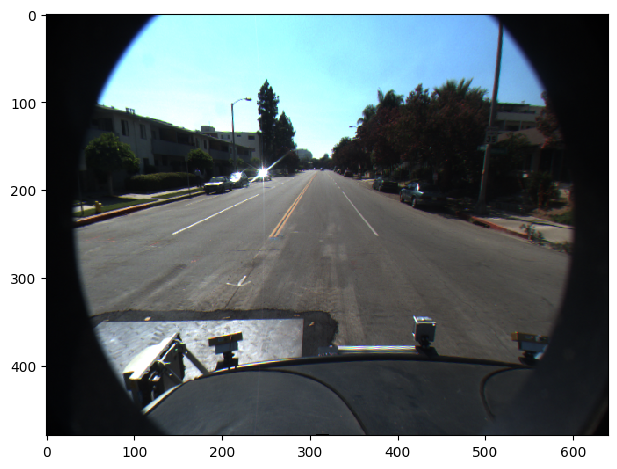

In [8]:
io.imshow(lane1)

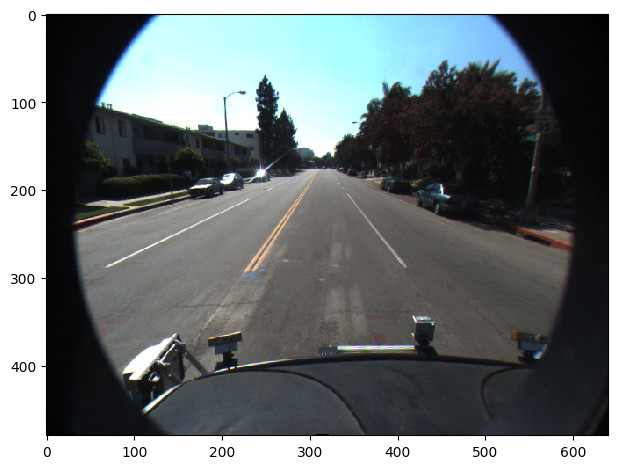

In [9]:
io.imshow(lane2)

### Task 5.2: Harris Corner Detection

* Implement the Harris Corner Detector as discussed in the lecture
* Compute and Plot the Harris Corners for the the two images given at the top of this assignment (**RESULT**)

In [12]:
# code here
from scipy import ndimage
import cv2
import numpy as np

sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

def harris_corner_detection(img, k=0.03, threshold=0.01):
    gray=color.rgb2gray(img)

    Ix = ndimage.convolve(gray, sobel_x)
    Iy = ndimage.convolve(gray, sobel_y)
    
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    
    Sxx = cv2.GaussianBlur(Ixx, (3, 3), sigmaX=1)
    Syy = cv2.GaussianBlur(Iyy, (3, 3), sigmaX=1)
    Sxy = cv2.GaussianBlur(Ixy, (3, 3), sigmaX=1)

    det_H = (Sxx * Syy) - (Sxy ** 2)
    trace_H = Sxx + Syy
    R = det_H - k * (trace_H ** 2)

    R_max = np.max(R)
    corners = np.zeros_like(R)
   
    corners[R > threshold * R_max] = 255
    
    # you can shrink them as you like
    dilated = cv2.dilate(R, None)
    cleaned = cv2.erode(dilated, None)
    corners = np.uint8(R == cleaned) * corners
    
    image_with_corners = np.copy(img)
    image_with_corners[corners > 0] = [255, 0, 0]

    return image_with_corners,corners

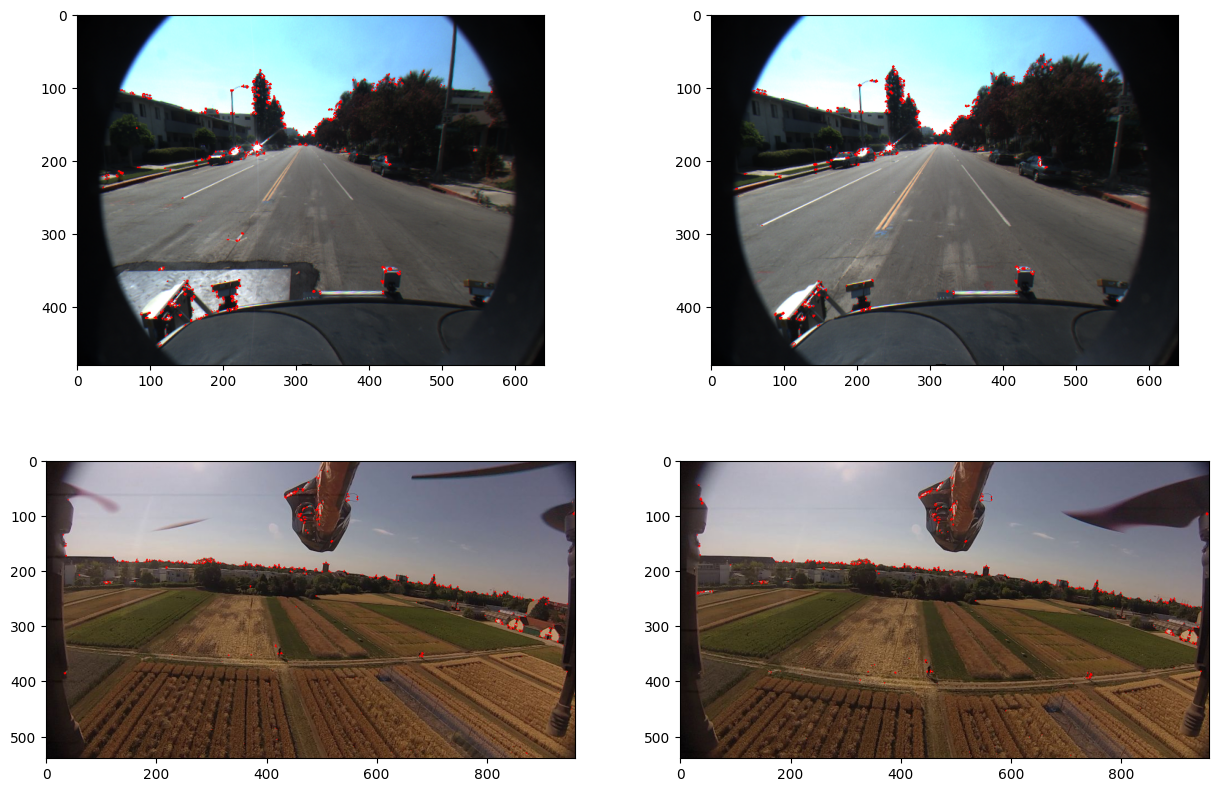

In [13]:
fig, axs = plt.subplots(2,2, figsize=(15, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, pic in enumerate([lane1, lane2, copter1, copter2]):
    pic_with_corners,_ = harris_corner_detection(pic)
    axs[i].imshow(pic_with_corners)

### Task 5.3: Lucas Kanade

* For the corner images from Task 5.2, track them with Lucas Kanade (feel free to use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* Mark the positions of your Harris Corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the two images given in the beginning of this assignment (**RESULT**)


In [15]:
def track_features(img1, img2, corners,step=1):
    corners_coords = np.argwhere(corners > 0)
    p0 = corners_coords[:, [1, 0]].astype(np.float32)
    p1, st, err = cv2.calcOpticalFlowPyrLK(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY),
                                           cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY),
                                           p0, None)
    valid = st.flatten() == 1
    p0_valid = p0[valid]
    p1_valid = p1[valid]

    p0_valid = p0_valid[0:len(p0_valid):step]
    p1_valid = p1_valid[0:len(p1_valid):step]
    
    return zip(p0_valid, p1_valid)

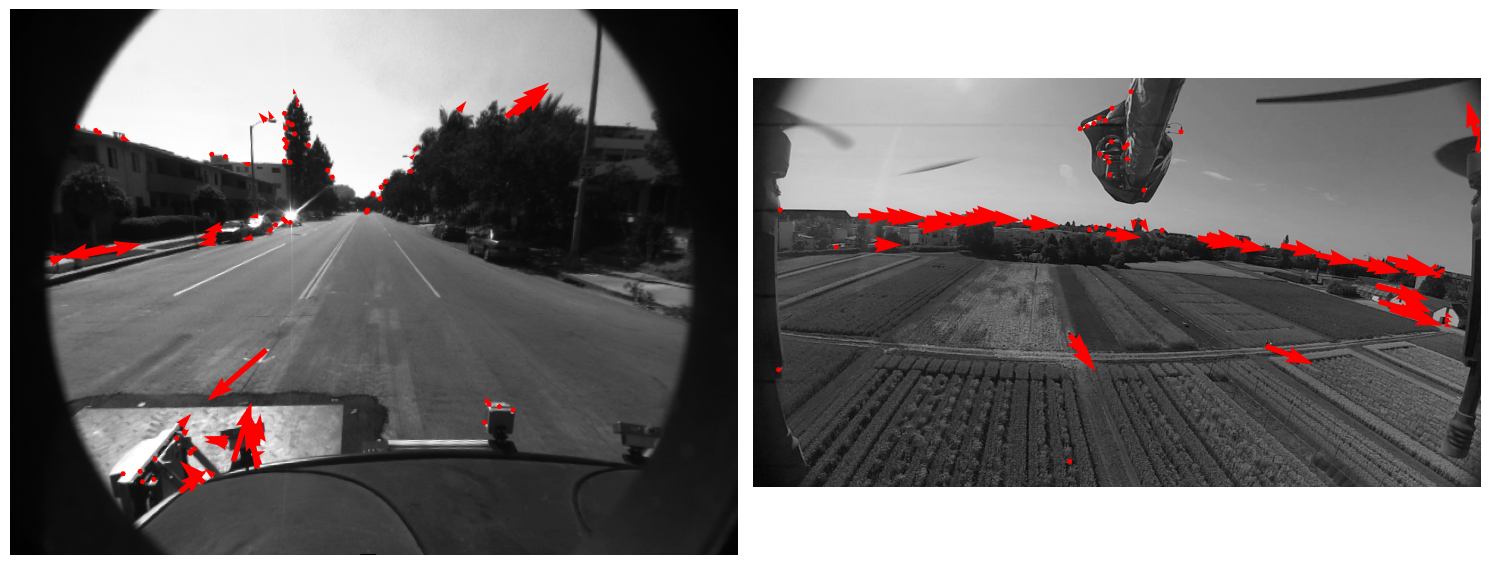

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()


image_pairs = [(lane1, lane2), (copter1, copter2)] 
step = 30

for i, (img1, img2) in enumerate(image_pairs):
    edge_points, corners = harris_corner_detection(img1)

    flow_vectors = track_features(img1, img2, corners, step=step)

    gray_img = color.rgb2gray(img1)
    axs[i].imshow(gray_img, cmap='gray', origin='upper')

  
    for (x0, y0), (x1, y1) in flow_vectors:
        u = x1 - x0
        v = y1 - y0
        axs[i].quiver(x0, y0, u, v, angles='xy', scale_units='xy', scale=1, color='red')

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


## Congratz, you made it! :)